### Compare CONUS2 and USGS streamflow ###
DTT, 10/22

This notebook reads in CSVs of CONUS2 daily mean flow [cms] and daily mean USGS flow [cms] and creates comparison hydrographs. Gages have been matched between the two csv's to make sure that we're comparing viable gage locations in `1_Organize_Streamflow.ipynb`. 

Inputs:
- CONUS2 daily mean flow csv in [cms], ouput from `1_Organize_Streamflow.ipynb`
- USGS daily mean flow csv in [cms], ouput from `1_Organize_Streamflow.ipynb` 
- USGS gage metadata csv, ouput from `1_Organize_Streamflow.ipynb` 

Outputs:
- Hydrographs of USGS and CONUS2 flow

Notes:
- as of 11/22 there are no stats included in these hydrographs. Need to either add a calculation here or pull from the SaveStreamflowStats.ipynb and add these to the plots

In [1]:
import sys
from parflow.tools.io import read_pfb,write_pfb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
#import geopandas as gpd

In [2]:
water_year = 2003
# Directory containing output csv's from `Make_CONUS2_streamflow_csv.py`
#organized_dir = '/glade/work/tijerina/PFCONUS2-analysis/scripts/Validation/Streamflow/Organized_Daily_Flow'
organized_dir = '/home/dtt2/CONUS2/PFCONUS2-analysis/scripts/Validation/Streamflow/Organized_Daily_Flow'
# Where you want to save plots, etc. to
#plot_dir = '/glade/work/tijerina/PFCONUS2-analysis/scripts/Validation/Streamflow/Figures'
plot_dir = '/home/dtt2/CONUS2/PFCONUS2-analysis/scripts/Validation/Streamflow/Figures'

# names of csv files
usgs_csv = 'USGS_Daily_matched_flow_cms_2003.csv'
pf_csv = 'PFCONUS2_Daily_matched_flow_cms_2003.csv'
metadata_csv = 'USGS_metadata_matched_flow_2003.csv'
stats_csv = 'Summary_Gages_CONUS2_WY2003.csv'

### Read in files
Read in PF flow, USGS flow, USGS metadata, and calculated stats from `SaveStreamflowStats.ipynb`

In [8]:
### read in CONUS2 daily flow matched csv
pfdata = pd.read_csv(f'{organized_dir}/{pf_csv}',index_col=['site_id'])
#pf_flow_matched = pfdata.drop(columns=['USGS_lat', 'USGS_lon', 'x_new_adj', 'y_new_adj'])
pfdata.head()

,2002-10-01,2002-10-02,2002-10-03,2002-10-04,2002-10-05,2002-10-06,2002-10-07,2002-10-08,2002-10-09,2002-10-10,...,2003-09-21,2003-09-22,2003-09-23,2003-09-24,2003-09-25,2003-09-26,2003-09-27,2003-09-28,2003-09-29,2003-09-30
site_id,,,,,,,,,,,,,,,,,,,,,
1011000,37.266464,34.151593,31.949418,28.746042,24.794453,21.037749,17.725660,14.927488,12.823219,11.328315,...,0.383030,0.248542,0.270354,0.370566,0.447849,0.437744,0.346303,1.857882,32.173826,0.0
1013500,18.686342,17.994405,17.171830,14.470901,14.358695,12.452931,11.061765,10.040905,9.119768,8.499280,...,0.542694,0.269608,0.231789,0.451696,0.321280,0.249696,0.204132,1.203276,30.743592,0.0
1015800,30.468728,29.614383,27.459663,24.822553,22.551353,19.456863,16.647201,14.524086,12.689513,11.405875,...,0.397749,0.306602,0.316849,0.505316,0.353142,0.297726,0.204833,0.469169,6.413734,0.0
1017000,64.752051,64.284799,62.117018,57.702024,52.771326,48.076338,43.703179,39.512687,35.268489,31.090277,...,1.916867,1.738682,1.658574,1.623249,1.463889,1.393643,1.341100,1.439029,3.284965,0.0
1017550,0.044492,0.028687,0.010159,0.003003,0.004380,0.001411,0.000000,0.000000,0.000000,0.000036,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


In [9]:
### read in USGS daily flow matched csv
usgsdata = pd.read_csv(f'{organized_dir}/{usgs_csv}',index_col=['site_id']) 
usgsdata.head()
# # change zero values in USGS df so that we can calculate stats without errors
# usgsdata = usgsdata.where(usgsdata>0, 0.0001)

,2002-10-01,2002-10-02,2002-10-03,2002-10-04,2002-10-05,2002-10-06,2002-10-07,2002-10-08,2002-10-09,2002-10-10,...,2003-09-21,2003-09-22,2003-09-23,2003-09-24,2003-09-25,2003-09-26,2003-09-27,2003-09-28,2003-09-29,2003-09-30
site_id,,,,,,,,,,,,,,,,,,,,,
1011000,7.414600,7.386300,6.990100,6.565600,6.36750,6.19770,5.744900,5.065700,4.528000,4.414800,...,12.650100,12.367100,11.942600,12.70670,13.697200,13.612300,13.159500,14.008500,66.2220,76.127000
1013500,3.509200,3.424300,3.169600,3.113000,3.33940,2.85830,2.858300,2.631900,2.405500,2.504550,...,14.376400,13.810400,13.612300,13.55570,13.159500,12.253900,11.942600,15.763100,58.2980,51.223000
1015800,6.707100,6.226000,5.716600,5.377000,5.15060,5.03740,4.754400,4.499700,4.160100,4.188400,...,3.763900,3.650700,3.537500,3.59410,3.735600,3.792200,3.707300,4.216700,25.4134,60.845000
1017000,9.876700,9.367300,8.461700,7.952300,7.81080,7.13160,7.046700,6.678800,6.282600,6.282600,...,7.075000,6.905200,6.792000,6.82030,6.820300,6.848600,6.763700,7.895700,50.6570,147.726000
1017550,0.023772,0.024338,0.020659,0.018395,0.01981,0.01981,0.018678,0.018678,0.018961,0.021791,...,0.080655,0.043016,0.049525,0.07358,0.053204,0.026319,0.023206,0.063675,0.1132,0.105559


In [10]:
### read in USGS streamflow gage metadata for all gages with flow in October
usgs_gage_metadata = pd.read_csv(f'{organized_dir}/{metadata_csv}',index_col=['site_id'])#, 
#usgs_gage_metadata = usgs_gage_metadata.drop(columns=['Unnamed: 0'])
#usgs_all_gages = usgs_all_gages.transpose() #transpose df for easier plotting
usgs_gage_metadata.head()

,site_type,agency,site_name,site_id_agency,site_query_url,date_metadata_last_updated,latitude,longitude,state,huc,...,topo_cd,instruments_cd,construction_dt,inventory_dt,drain_area_va,contrib_drain_area_va,local_time_fg,reliability_cd,project_no,num_obs
site_id,,,,,,,,,,,,,,,,,,,,,
1011000,stream gauge,USGS,"Allagash River near Allagash, Maine",1011000,https://waterservices.usgs.gov/nwis/site/?form...,2022-08-30,47.069722,-69.079444,ME,1010002,...,NaN,YNNNYNNNNYNNNNNNYNNNNNNNNNNNNN,NaN,NaN,1478.00,1229.00,Y,NaN,442300100.0,365
1013500,stream gauge,USGS,"Fish River near Fort Kent, Maine",1013500,https://waterservices.usgs.gov/nwis/site/?form...,2022-08-30,47.237500,-68.582778,ME,1010003,...,NaN,YNNNYNYNNYNNNNNNYNNNNNNNNNNNNN,NaN,NaN,873.00,873.00,Y,NaN,442300100.0,365
1015800,stream gauge,USGS,"Aroostook River near Masardis, Maine",1015800,https://waterservices.usgs.gov/nwis/site/?form...,2022-08-30,46.523056,-68.371667,ME,1010004,...,NaN,YNNNYNYNNYNNNNNNYNNNNNNNNNNNNN,NaN,NaN,892.00,892.00,Y,NaN,442300100.0,365
1017000,stream gauge,USGS,"Aroostook River at Washburn, Maine",1017000,https://waterservices.usgs.gov/nwis/site/?form...,2022-08-30,46.777222,-68.157222,ME,1010004,...,NaN,YNNNYNYNNYNNNNNNYNNNNNNNNNNNNN,NaN,NaN,1654.00,1654.00,Y,NaN,442300100.0,365
1017550,stream gauge,USGS,"Williams Brook at Phair, Maine",1017550,https://waterservices.usgs.gov/nwis/site/?form...,2022-08-30,46.628056,-67.953056,ME,1010005,...,NaN,YNNNYNYNNYNNNNNNYNNNNNNNNNNNNN,NaN,NaN,3.82,3.82,Y,NaN,442300100.0,365


In [4]:
### read in USGS daily flow matched csv
stats_df = pd.read_csv(f'{organized_dir}/{stats_csv}',index_col=['site_id']) 
stats_df.head()

,latitude,longitude,conus2_x,conus2_y,USGS_mean_cms,PF_mean_cms,absrelbias,bias,pbias,srho,mse,rmse,r2
site_id,,,,,,,,,,,,,
1011000,47.069722,-69.079444,4210,2783,41.836549,29.714315,0.289752,-0.289752,-28.975225,0.706543,0.0,0.0,0.598717
1013500,47.237500,-68.582778,4237,2810,39.405556,18.607378,0.527798,-0.527798,-52.779810,0.517411,0.0,0.0,0.220357
1015800,46.523056,-68.371667,4276,2747,33.593030,27.100917,0.193258,-0.193258,-19.325775,0.816297,0.0,0.0,0.563045
1017000,46.777222,-68.157222,4281,2773,66.854292,58.205067,0.129374,-0.129374,-12.937427,0.708347,0.0,0.0,0.623226
1017550,46.628056,-67.953056,4300,2762,0.142967,0.063122,0.558483,-0.558483,-55.848308,0.364924,0.0,0.0,-0.243661


In [9]:
len(usgsdata.columns)

365

## Make USGS-CONUS2 timeseries plots 
Plot a hydrograph at each gage for USGS observations and PF-CONUS2

In [71]:
pfdata.columns

'2002-10-01'

In [118]:
### Make a plot of CONUS2 vs observed
xlength = range(len(usgsdata.columns))
xlength = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in pfdata.columns]

for i in range(len(usgsdata.index)):
    gage = usgsdata.index[i]
    station_name = usgs_gage_metadata['site_name'][gage]
    

    # make hydrographs
    fig, ax = plt.subplots(figsize=(7,5), dpi = 200)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    #plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    ax.plot(xlength, pfdata.loc[gage],label= 'PF-CONUS2')
    ax.plot(xlength, usgsdata.loc[gage],label= 'USGS')
    #plt.gcf().autofmt_xdate()
    ax.set_ylabel('flow [cms]')
    #plt.xlabel('Days')
    plt.title(f'Mean Daily Flow - {station_name}')
    plt.annotate(f'Bias: {round(stats_df.bias.iloc[i],3)}\nSrho: {round(stats_df.srho.iloc[i],3)}\nR\u00b2: {round(stats_df.r2.iloc[i],3)}',xy=(0.05,0.86), xycoords = 'axes fraction')
    ax.legend()
    plt.savefig(f'{plot_dir}/Timeseries_WY2003/Timeseries_{usgsdata.index[i]}_cms.png',facecolor='white', transparent=False, bbox_inches="tight")
    plt.close()

## Make CONUS2 summary stat plots

USGS vs PF mean daily flow

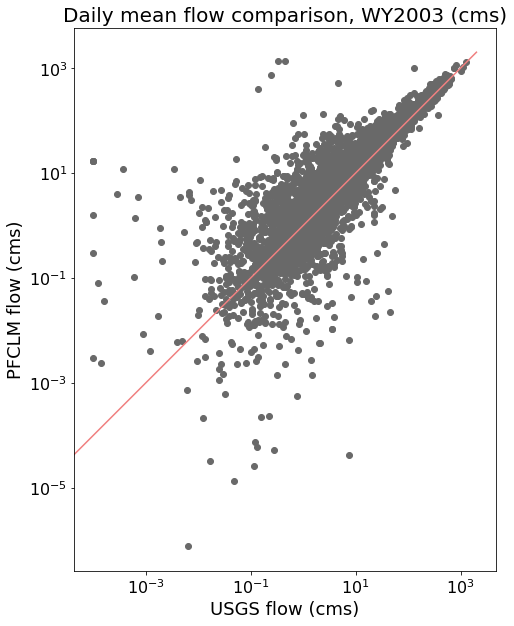

In [18]:
# Scatter plot of daily mean flow for  WY2003, PF vs. USGS
fig = plt.figure(figsize=(10,10), dpi=72)
ax = fig.add_subplot()

ax.scatter(stats_df['USGS_mean_cms'], stats_df['PF_mean_cms'], color = 'dimgrey')
ax.plot(range(2000), color = 'lightcoral')
plt.ylabel('PFCLM flow (cms)',fontsize=18)
plt.xlabel('USGS flow (cms)',fontsize=18)
plt.title('Daily mean flow comparison, WY2003 (cms)',fontsize=20)
ax.set_xscale('log')
ax.set_yscale('log')
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
# square plot
ax.set_aspect('equal', adjustable='box')
plt.savefig(f'{plot_dir}/WY2003_daily_mean_flow_comparison_scatter.png')


<AxesSubplot:>

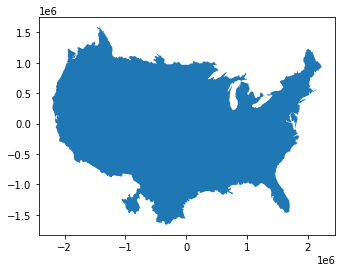

In [28]:
shp_dir = '/glade/p/univ/ucsm0009/CONUS2/domain_files/CONUS2_domain_LCC.shp'
conus2_shp = gpd.read_file(shp_dir)
conus2_shp.plot()

In [31]:

from shapely.geometry import Point

/glade/work/tijerina/conda-envs/parflow-npl/lib/python3.7/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


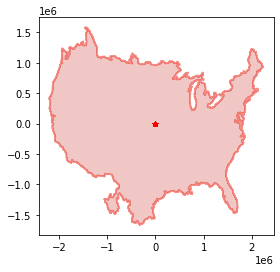

In [40]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

long = stats_df.longitude
lat = stats_df.latitude
geometry = [Point(xy) for xy in zip(long,lat)]

#ward = gpd.read_file(wardlink, bbox=None, mask=None, rows=None)
geo_df = gpd.GeoDataFrame(geometry = geometry)

conus2_shp.crs = {'init':"epsg:4326"}
geo_df.crs = {'init':"epsg:4326"}

# plot the polygon
ax = conus2_shp.plot(alpha=0.35, color='#d66058', zorder=1)
# plot the boundary only (without fill), just uncomment
ax = gpd.GeoSeries(conus2_shp['geometry'].unary_union).boundary.plot(ax=ax, alpha=0.5, color="#ed2518",zorder=2)

# plot the marker
ax = geo_df.plot(ax = ax, markersize = 20, color = 'red',marker = '*', zorder=3)

In [41]:
geo_df

,geometry
0,POINT (-69.07944 47.06972)
1,POINT (-68.58278 47.23750)
2,POINT (-68.37167 46.52306)
3,POINT (-68.15722 46.77722)
4,POINT (-67.95306 46.62806)
...,...
4956,POINT (-123.14005 42.24151)
4957,POINT (-123.40673 42.35401)
4958,POINT (-124.05814 42.57844)
4959,POINT (-123.66368 42.23178)


In [29]:
conus2_shp.crs
#inProj = Proj(init='epsg:4326')

<Projected CRS: ESRI:102004>
Name: USA_Contiguous_Lambert_Conformal_Conic
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

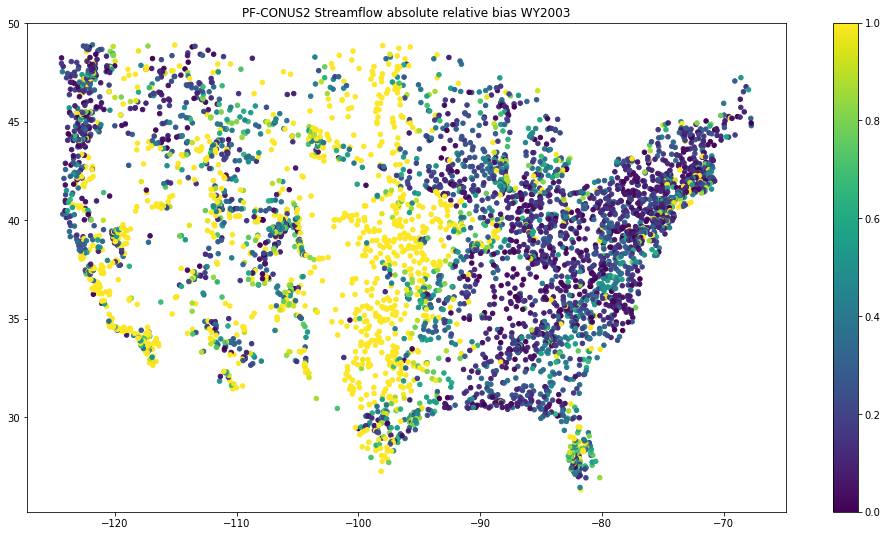

In [5]:
### Absolute Relative Bias
### Good values are closer to 0.0
fig = plt.figure(figsize=(17,9), dpi=72)
plt.scatter(stats_df.longitude,stats_df.latitude, c=stats_df.absrelbias, s=20, vmin = 0, vmax = 1)
plt.colorbar()
plt.title(f'PF-CONUS2 Streamflow absolute relative bias WY{water_year}')
plt.savefig(f'{plot_dir}/PFCONUS2_AbsRelBias_Map_WY{water_year}.png',\
            dpi = 200, facecolor='white', transparent=False, bbox_inches="tight")

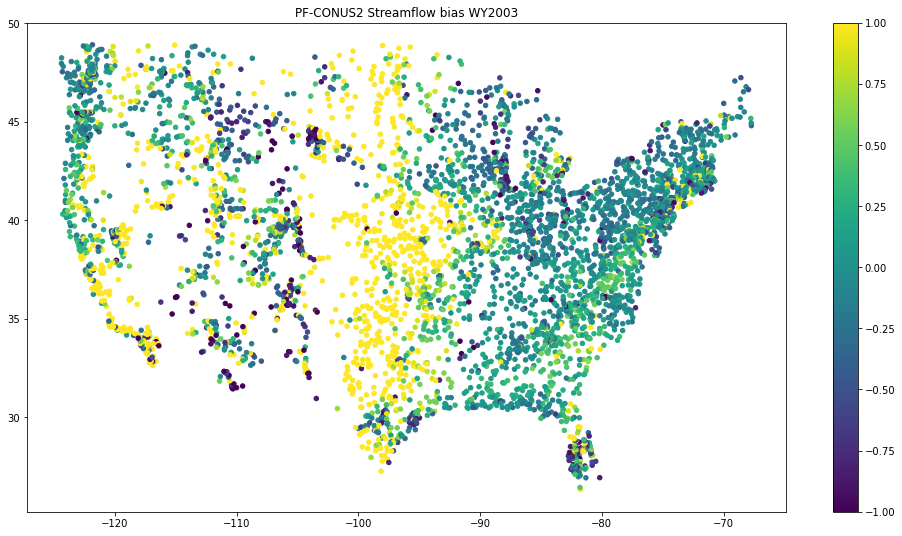

In [6]:
### Relative Bias
### Good values are closer to 0.0, positive is PF overestimation, negative is PF underestimation
fig = plt.figure(figsize=(17,9), dpi=72)
plt.scatter(stats_df.longitude,stats_df.latitude, c=stats_df.bias, s=20, vmin = -1, vmax = 1)
plt.colorbar()
plt.title(f'PF-CONUS2 Streamflow bias WY{water_year}')
plt.savefig(f'{plot_dir}/PFCONUS2_RelBias_Map_WY{water_year}.png',\
            dpi = 200, facecolor='white', transparent=False, bbox_inches="tight")

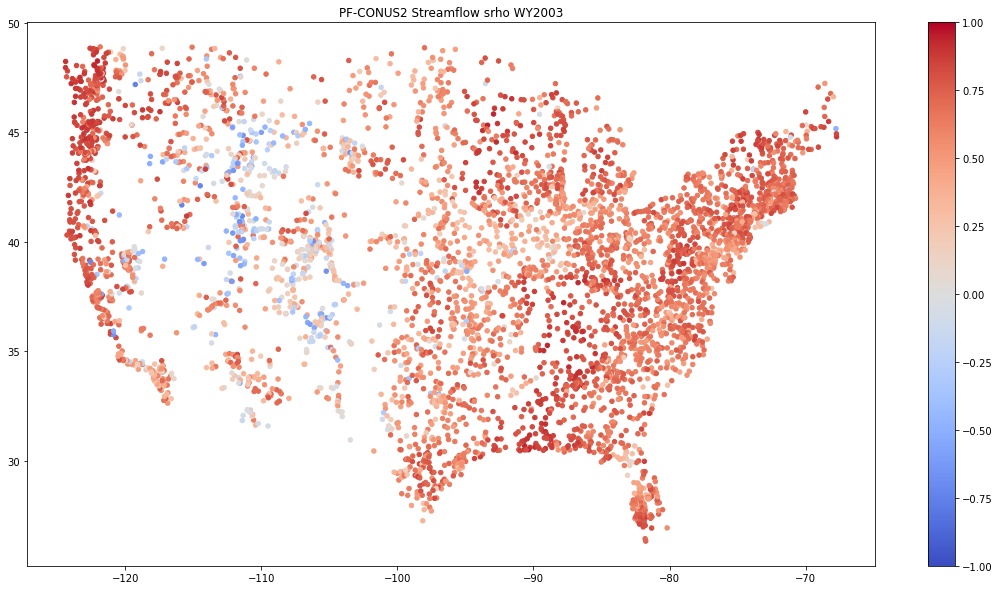

In [7]:
fig = plt.figure(figsize=(19,10), dpi=72)
plt.scatter(stats_df.longitude,stats_df.latitude, c=stats_df.srho, s=20, vmin = -1, vmax = 1, cmap = 'coolwarm')
plt.colorbar()
plt.title(f'PF-CONUS2 Streamflow srho WY{water_year}')
plt.savefig(f'{plot_dir}/PFCONUS2_Srho_Map_WY{water_year}.png',\
            dpi = 200, facecolor='white', transparent=False, bbox_inches="tight")